In [1]:
!pip install sentence_transformers
!pip install einops
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import glob

In [4]:
import einops
import torch
from torch.cuda.amp import autocast
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers.utils.import_utils import is_nltk_available, NLTK_IMPORT_ERROR # This is a dependency of sentence_trasnformers. Had to manually import for some reason...
from sentence_transformers import SentenceTransformer, losses, models
from sentence_transformers.losses import MatryoshkaLoss
from transformers import AutoModel
from tqdm import tqdm
from typing import Type, Any, Callable, Union, List, Optional

In [5]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
# elif torch.backends.mps.is_available():
#     DEVICE = 'mps'
else:
    DEVICE = 'cpu'
LR              = 1e-3
MOMENTUM        = 0.9
BATCH_SIZE      = 2
NUM_EPOCHS      = 1
DATASET_ID      = "coastalcph/lex_glue"
MODEL_ID        = 'nomic-ai/nomic-embed-text-v1.5'
NESTING_LIST    = [12, 24, 48, 96, 192, 384, 768] # Matryoshka nested dimensions
EFFICIENT       = True # Set to true for MRL-Efficient (see MRL paper for more details)

In [6]:
'''
Loss function for Matryoshka Representation Learning
'''
class Matryoshka_CE_Loss(nn.Module):
	def __init__(self, relative_importance: List[float]=None, **kwargs):
		super(Matryoshka_CE_Loss, self).__init__()
		self.criterion = nn.CrossEntropyLoss(**kwargs)
		# relative importance shape: [G]
		self.relative_importance = relative_importance

	def forward(self, output, target):
		# output shape: [G granularities, N batch size, C number of classes]
		# target shape: [N batch size]

		# Calculate losses for each output and stack them. This is still O(N)
		losses = torch.stack([self.criterion(output_i, target) for output_i in output])

		# Set relative_importance to 1 if not specified
		rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.tensor(self.relative_importance)

		# Apply relative importance weights
		weighted_losses = rel_importance * losses
		return weighted_losses.sum()


In [7]:
class MRL_Linear_Layer(nn.Module):
    '''
    MRL Linear layer attached on top of the embedding model for classification tasks
    '''

    def __init__(self, nesting_list: List, num_classes=1000, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes # Number of classes for classification
        self.efficient = efficient
        if self.efficient:
            setattr(self, f"nesting_classifier_{0}", nn.Linear(nesting_list[-1], self.num_classes, **kwargs))
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def reset_parameters(self):
        if self.efficient:
            self.nesting_classifier_0.reset_parameters()
        else:
            for i in range(len(self.nesting_list)):
                getattr(self, f"nesting_classifier_{i}").reset_parameters()


    def forward(self, x):
        # x shape: [N batch size, D dimension of embedding model (768)]

        nesting_logits = ()

        for i, num_feat in enumerate(self.nesting_list):

            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits +=  (getattr(self, f"nesting_classifier_{i}")(x[:,mat :num_feat]),)

        return nesting_logits


class FixedFeatureLayer(nn.Linear):
    '''
    For our fixed feature baseline, we just replace the classification layer with the following.
    It effectively just look at the first "in_features" for the classification.
    '''

    def __init__(self, in_features, out_features, **kwargs):
        super(FixedFeatureLayer, self).__init__(in_features, out_features, **kwargs)

    def forward(self, x):
        if not (self.bias is None):
            out = torch.matmul(x[:, :self.in_features], self.weight.t()) + self.bias
        else:
            out = torch.matmul(x[:, :self.in_features], self.weight.t())
        return out

class NomicSentenceTransformerWithLinearProbe(nn.Module):
    def __init__(self, model_name, num_classes, nesting_list: List, efficient=True):
        super(NomicSentenceTransformerWithLinearProbe, self).__init__()

        # Load the sentence transformer model
        self.sentence_transformer = SentenceTransformer(model_name, trust_remote_code=True)
        max_embedding_dimension = self.sentence_transformer.get_sentence_embedding_dimension()

        # Sanity check to ensure the max_embedding_dimension of the sentence transformer
        # is equal to max embeding dimension in nesting_list
        assert max(nesting_list) == max_embedding_dimension

        # MRL linear layer (linear probe)
        self.MRL_linear_layer = MRL_Linear_Layer(nesting_list, num_classes, efficient)

    def forward(self, x):
        # x shape: [N batch size]

        # Pass the input through the sentence transformer
        embeddings = self.sentence_transformer.encode(x, convert_to_tensor=True)

        # embeddings shape: [N batch size, D dimension of embedding model (768)]

        # Pass through the MRL_linear_layer to get logits
        logits = self.MRL_linear_layer(embeddings)

        return logits

class NomicSentenceTransformerWithLinearProbeForMCQ(nn.Module):
    def __init__(self, model_name, num_classes, nesting_list: List, efficient=True):
        super(NomicSentenceTransformerWithLinearProbeForMCQ, self).__init__()

        # Load the sentence transformer model
        self.sentence_transformer = SentenceTransformer(model_name, trust_remote_code=True)
        max_embedding_dimension = self.sentence_transformer.get_sentence_embedding_dimension()

        # Sanity check to ensure the max_embedding_dimension of the sentence transformer
        # is equal to max embeding dimension in nesting_list
        assert max(nesting_list) == max_embedding_dimension

        # MRL linear layer (linear probe)
        self.MRL_linear_layer = MRL_Linear_Layer(nesting_list, num_classes, efficient)

    # Modified to handle multiple-choice inputs
    # x shape: [N batch size]
    def forward(self, context, endings):

        logits = []
        for ending in endings:
            input_text = context + " " + ending[0]
            embedding = self.sentence_transformer.encode(input_text, convert_to_tensor=True)
            logit = self.MRL_linear_layer(embedding.unsqueeze(0))

            logit = logit[0]  # Extract the tensor from the tuple
            logit = logit.squeeze(-1).unsqueeze(0)  # Ensure logit is 2D with shape [1, 1]
            logits.append(logit)
        logits = torch.cat(logits, dim=1)  # Concatenate logits along the second dimension

        return (logits,)

In [124]:
mcq_model = NomicSentenceTransformerWithLinearProbeForMCQ(model_name=MODEL_ID,
                                                num_classes=1,
                                                nesting_list=NESTING_LIST,
                                                efficient=EFFICIENT)
mcq_model.to(DEVICE)

path = '/content/mrl_mcq_bs4_two_unfreezed_layers.pth'
mcq_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [119]:
scotus_model = NomicSentenceTransformerWithLinearProbe(model_name=MODEL_ID,
                                                num_classes=13,
                                                nesting_list=NESTING_LIST,
                                                efficient=EFFICIENT)

In [120]:
scotus_model.to('cpu')

NomicSentenceTransformerWithLinearProbe(
  (sentence_transformer): SentenceTransformer(
    (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: NomicBertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  )
  (MRL_linear_layer): MRL_Linear_Layer(
    (nesting_classifier_0): Linear(in_features=768, out_features=13, bias=True)
  )
)

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

NotImplementedError: google.colab.drive is unsupported in this environment.

In [121]:
path = '/mrl_scotus_bs1.pth'
scotus_model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

RuntimeError: Error(s) in loading state_dict for NomicSentenceTransformerWithLinearProbe:
	size mismatch for MRL_linear_layer.nesting_classifier_0.weight: copying a param with shape torch.Size([1, 768]) from checkpoint, the shape in current model is torch.Size([13, 768]).
	size mismatch for MRL_linear_layer.nesting_classifier_0.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([13]).

In [45]:
scotus_model.to(DEVICE)

NomicSentenceTransformerWithLinearProbe(
  (sentence_transformer): SentenceTransformer(
    (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: NomicBertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  )
  (MRL_linear_layer): MRL_Linear_Layer(
    (nesting_classifier_0): Linear(in_features=768, out_features=13, bias=True)
  )
)

In [9]:
def chunk_text(text, chunk_size=500):
    words = text.split()
    chunks = []
    current_chunk = []

    for word in words:
        current_chunk.append(word)
        if len(current_chunk) == chunk_size:
            chunks.append(" ".join(current_chunk))
            current_chunk = []

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

In [10]:
def get_chunks(path):
  with open(path, 'r', encoding='utf-8') as file:
    html_content = file.read()

  soup = BeautifulSoup(html_content, 'html.parser')
  text_val = soup.text.replace('\n','')
  chunked = chunk_text(text_val,500)
  return(chunked)

In [11]:
matryoshka_dim = 768

# model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)
# sentences = ['search_query: What is TSNE?', 'search_query: Who is Laurens van der Maaten?']
# embeddings = model.encode(sentences, convert_to_tensor=True)
# embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
# embeddings = embeddings[:, :matryoshka_dim]
# embeddings = F.normalize(embeddings, p=2, dim=1)
# print(embeddings)

In [8]:
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

configuration_hf_nomic_bert.py:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-embed-text-v1-unsupervised:
- configuration_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hf_nomic_bert.py:   0%|          | 0.00/52.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-embed-text-v1-unsupervised:
- modeling_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [127]:
def get_document_embeddings_v2(text, model, matryoshka_dim):
  text = 'search_document: '+ text
  embeddings = model.sentence_transformer.encode([text], convert_to_tensor=True)
  embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
  embeddings = embeddings[:, :matryoshka_dim]
  embeddings = F.normalize(embeddings, p=2, dim=1)
  return(embeddings[0])

In [128]:
def get_query_embeddings_v2(text, model, matryoshka_dim):
  text = 'search_query: '+ text
  embeddings = model.sentence_transformer.encode([text], convert_to_tensor=True)
  embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
  embeddings = embeddings[:, :matryoshka_dim]
  embeddings = F.normalize(embeddings, p=2, dim=1)
  return(embeddings[0])

In [9]:
def get_document_embeddings(text, model, matryoshka_dim):
  text = 'search_document: '+ text
  embeddings = model.encode([text], convert_to_tensor=True)
  embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
  embeddings = embeddings[:, :matryoshka_dim]
  embeddings = F.normalize(embeddings, p=2, dim=1)
  return(embeddings[0])

In [10]:
def get_query_embeddings(text, model, matryoshka_dim):
  text = 'search_query: '+ text
  embeddings = model.encode([text], convert_to_tensor=True)
  embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
  embeddings = embeddings[:, :matryoshka_dim]
  embeddings = F.normalize(embeddings, p=2, dim=1)
  return(embeddings[0])

In [ ]:
# chunked = get_chunks('/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc18a.htm')

In [16]:
list_emb = []
list_text = []
list_id = []
for i in glob.glob('/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/*'):
#for i in glob.glob('/content/htm_uscAll@118-44/*'):
  print(i)
  m = 0
  id = i.split('/')[-1].replace('.','_')
  try:
    chunked = get_chunks(i)
  except:
    print(i)
  for j in chunked:
    list_text.append(j)
    list_emb.append(np.array(get_document_embeddings(j,model,768).cpu()))
    list_id.append(id+'_{}'.format(m))
    m = m+1

/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc01.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc05a.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc05.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc04.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc03.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc06.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc02.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc09.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc08.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc07.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc10.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc11.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc13.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc15.htm
/content/drive/MyDrive/AdvTopics/htm_uscAll@118-44/PRELIMusc1

In [17]:
df = pd.DataFrame(zip(list_id,list_emb,list_text),columns=['id','embeddings','text'])

In [19]:
df.to_parquet('/content/drive/MyDrive/AdvTopics/total_chunks_768_nomic.parquet')

In [ ]:
######################

In [1]:
import pandas as pd

In [13]:
df = pd.read_parquet('/content/drive/MyDrive/AdvTopics/total_chunks_768_nomic.parquet')

In [14]:
df.shape

(92695, 3)

In [15]:
matryoshka_dim = 768

In [16]:
def search_and_rank_without_MRL(query, df, model, matryoshka_dim):

    query_embedding = get_query_embeddings(query, model, matryoshka_dim)
    query_embedding_arr = np.array(query_embedding.cpu())

    # Convert the 'embeddings' column back to numpy array
    df_embeddings = np.array(df['embeddings'].tolist())

    start_time = time.time()
    # Calculate similarities (cosine similarity)
    similarities = cosine_similarity(query_embedding_arr.reshape(1, -1), df_embeddings).flatten()

    # Get the indices of the top 10 most similar entries
    top_indices = np.argsort(similarities)[::-1][:10]

    # Get the titles of the top 10 results
    top_titles = df.iloc[top_indices]['text']
    print(top_titles)

    # End time
    end_time = time.time()

    # Calculate duration
    duration = end_time - start_time

    print(f"The operation took {duration} seconds.")

    return (top_titles.tolist(),duration)

In [17]:
query = "If I jump a red light, how will I be punished?"

In [19]:
search_and_rank_without_MRL(query, df,model,matryoshka_dim)

89223    conviction, be subject for each offense to imp...
90229    an airport security badge or other identifier ...
81969    by imprisonment for not more than 2 years, or ...
34067    the surface under part 71 of title 14, Code of...
51348    or other mine in which a violation occurs of a...
90254    with intent to commit, in the aircraft or airp...
87879    for classification] and this Act [see Tables f...
22934    penaltyIt shall be unlawful for any person, or...
90248    107–296 as of Nov. 25, 2002, see section 211 o...
90249    fined under title 18 if the air carrier, forei...
Name: text, dtype: object
The operation took 0.7571418285369873 seconds.


(['conviction, be subject for each offense to imprisonment for a term not to exceed one year or a fine under title 18, or both.(j) Grade-Crossing Violations.—(1) Sanctions.—The Secretary shall issue regulations establishing sanctions and penalties relating to violations, by persons operating commercial motor vehicles, of laws and regulations pertaining to railroad-highway grade crossings.(2) Minimum requirements.—The regulations issued under paragraph (1) shall, at a minimum, require that—(A) the penalty for a single violation is not less than a 60-day disqualification of the driver\'s commercial driver\'s license; and(B) any employer that knowingly allows, permits, authorizes, or requires an employee to operate a commercial motor vehicle in violation of such a law or regulation shall be subject to a civil penalty of not more than $10,000.(k) Foreign Commercial Drivers.—A foreign commercial driver shall be subject to disqualification under this section.(Pub. L. 103–272, §1(e), July 5, 

In [20]:
def normalize_l2(x):
    x = np.array(x)
    if x.ndim == 1:
        norm = np.linalg.norm(x)
        if norm == 0:
            return x
        return x / norm
    else:
        norm = np.linalg.norm(x, 2, axis=1, keepdims=True)
        return np.where(norm == 0, x, x / norm)


def get_short_embeddings(df_w_embeddings,short_dim):
    df_w_embeddings['normalized_embeddings'] = df_w_embeddings['embeddings'].apply(lambda x: normalize_l2(x[:short_dim]))
    return df_w_embeddings

In [72]:
df = get_short_embeddings(df,128)

In [22]:
def search_and_rank_with_MRL(query, df, model, matryoshka_dim,short_dim):

    #print(f"Search query : {query}")

    query_embedding = get_query_embeddings(query, model, matryoshka_dim)
    query_embedding_arr = np.array(query_embedding.cpu())
    # Generate the embedding for the query
    query_embedding = get_query_embeddings(query, model, matryoshka_dim)
    query_embedding_arr_short = np.array(normalize_l2(query_embedding.cpu()[:short_dim]))

    # Phase 1
    # Convert the 'embeddings' column back to numpy array
    df_embeddings = np.array(df['normalized_embeddings'].tolist())

    start_time = time.time()
    # Calculate similarities (cosine similarity)
    similarities = cosine_similarity(query_embedding_arr_short.reshape(1, -1), df_embeddings).flatten()

    # Get the indices of the top 20 most similar entries
    top_indices_unranked = np.argsort(similarities)[::-1][:20]

    # Phase 2
    top_unranked_embeddings = np.array(df.iloc[top_indices_unranked]['embeddings'].tolist())
    refined_similarities = cosine_similarity(np.array(query_embedding.cpu()).reshape(1, -1), top_unranked_embeddings).flatten()

    # Get the indices of the top 10 most similar entries, based on refined similarities
    top_indices = top_indices_unranked[np.argsort(refined_similarities)[::-1][:10]]

    # Get the titles of the top 10 results
    top_titles = df.iloc[top_indices]['text']

    # End time
    end_time = time.time()

    # Calculate duration
    duration = end_time - start_time

    #print(f"The operation took {duration} seconds.")

    return (top_titles.tolist(),duration)

In [24]:
import pandas as pd

# Path to your TSV file
file_path = '/content/drive/MyDrive/AdvTopics/data_rule_qa_test.tsv'

# Load the TSV file into a DataFrame
rule_qa = pd.read_csv(file_path, delimiter='\t')

# Display the first few rows of the DataFrame
print(rule_qa.head())

   index                                               text  \
0      0  What are the requirements for diversity jurisd...   
1      1          Where is diversity jurisdiction codified?   
2      2       Where is supplemental jurisdiction codified?   
3      3  What test is used to determine a corporation's...   
4      4  Where in the Federal Rules of Civil Procedure ...   

                                              answer         doctrine  
0  Diversity jurisdiction exists when the amount ...  Civil Procedure  
1                                      28 USC § 1332  Civil Procedure  
2                                   28 U.S.C. § 1367  Civil Procedure  
3                                  Nerve center test  Civil Procedure  
4                                            Rule 23  Civil Procedure  


In [82]:
time_ls = []
for i in rule_qa['text']:
  _,time1 = search_and_rank_without_MRL(i, df,model,matryoshka_dim)
  time_ls.append(time1)

12591    the notice of default and foreclosure sale sha...
67436    of title 5, transfer accrued annual and sick l...
69789    28765632 2912, 29135633 2914(a)5634 2806(a)(1)...
10055    the Secretary of State, and so certified by th...
51771    [42 U.S.C. 2053] ("Research for Others"); prov...
32143    of an Army Group, an Army, an Army Corps, a di...
9052     a note under section 552a of Title 5, Governme...
35112    disposal.(6) Natural gas.(7) Pest control.(8) ...
58465    a plan describing the process for the disposit...
190      of guideline sentencing vis a vis plea agreeme...
Name: text, dtype: object
The operation took 0.24027109146118164 seconds.
55078    82 F.R. 16093, which related to certain regula...
57367    109–295 inserted "fire," after "safety,".Statu...
9961     "affiliate" has the same meaning as in section...
22457    Savings Act'."Pub. L. 113–170, §1, Sept. 26, 2...
88330    this section referred to as the "Commission"),...
22458    'OPEN FOIA Act of 2009'."Pub. L.

In [84]:
np.mean(time_ls)

0.23992865562438964

In [88]:
time_ls = []
for i in rule_qa['text']:
  _,time1 = search_and_rank_with_MRL(i, df, scotus_model, matryoshka_dim,128)
  time_ls.append(time1)

Search query : What are the requirements for diversity jurisdiction?
The operation took 0.05147385597229004 seconds.
Search query : Where is diversity jurisdiction codified?
The operation took 0.050708770751953125 seconds.
Search query : Where is supplemental jurisdiction codified?
The operation took 0.04920077323913574 seconds.
Search query : What test is used to determine a corporation's principal place of business for the purpose of diversity jurisdiction?
The operation took 0.05702638626098633 seconds.
Search query : Where in the Federal Rules of Civil Procedure are class action requirements described?
The operation took 0.05160403251647949 seconds.
Search query : Per the Hertz "nerve center" test, where is a corporation's principal place of business?
The operation took 0.052779197692871094 seconds.
Search query : What are the four requirements for class certification under the Federal Rules of Civil Procedure?
The operation took 0.04895591735839844 seconds.
Search query : What are

In [89]:
np.mean(time_ls)

0.05154035091400146

In [134]:
time_mean_ls = []
size_ls = []
for j in [12, 24, 48, 64, 96, 128, 192, 256, 384, 512, 768]:
  time_ls = []
  df = get_short_embeddings(df,j)
  for i in rule_qa['text']:
    _,time1 = search_and_rank_with_MRL(i, df, scotus_model, matryoshka_dim,j)
    time_ls.append(time1)
  print(j,"=====",np.mean(time_ls))
  time_mean_ls.append(np.mean(time_ls))
  size_ls.append(j)

12 ===== 0.024917745590209962
24 ===== 0.02642740249633789
48 ===== 0.03365444660186768
64 ===== 0.03627735137939453
96 ===== 0.04510468006134033
128 ===== 0.05433979034423828
192 ===== 0.06846103668212891
256 ===== 0.08474870204925537
384 ===== 0.14051446437835693
512 ===== 0.17988829612731932
768 ===== 0.25165643215179445


In [138]:
import matplotlib.pyplot as plt


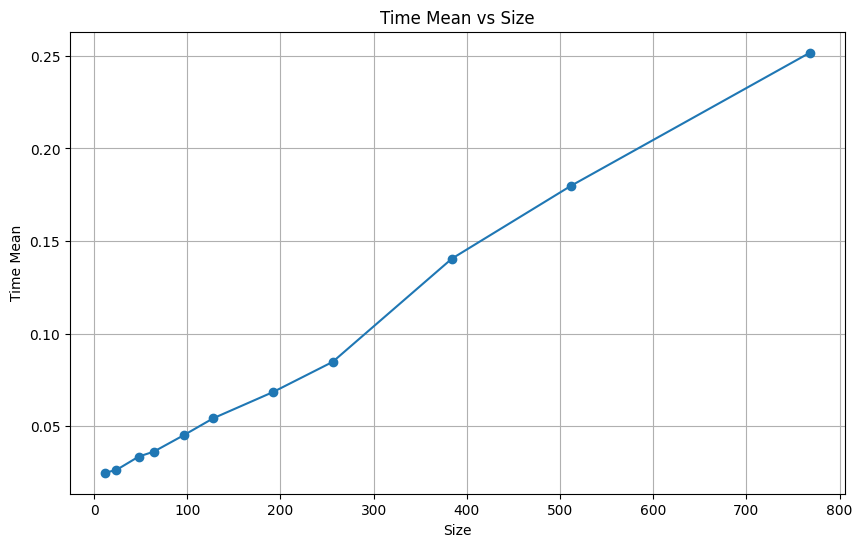

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(size_ls, time_mean_ls, marker='o')
plt.title('Time Mean vs Size')
plt.xlabel('Size')
plt.ylabel('Time Mean')
plt.grid(True)
plt.show()

RAG

In [61]:

ls,_ = search_and_rank_with_MRL("Where in the Federal Rules of Civil Procedure are class action requirements described?", df, model, matryoshka_dim, 256)

In [63]:
ls[1]

"character of the paper.Notes of Advisory Committee on Rules—1983Subdivision (b). Additional requirements applicable to the caption for a petition are found in Rule 1005, to the caption for notices to creditors in Rule 2002(m), and to the caption for a pleading or other paper filed in an adversary proceeding in Rule 7010. Failure to comply with this or any other rule imposing a merely formal requirement does not ordinarily result in the loss of rights. See Rule 9005.Rule 9005. Harmless ErrorRule 61 F.R.Civ.P. applies in cases under the Code. When appropriate, the court may order the correction of any error or defect or the cure of any omission which does not affect substantial rights.References in TextThe Federal Rules of Civil Procedure, referred to in text, are set out in the Appendix to Title 28, Judiciary and Judicial Procedure.Rule 9005.1. Constitutional Challenge to a Statute—Notice, Certification, and InterventionRule 5.1 F.R.Civ.P. applies in cases under the Code.(Added Apr. 30

In [25]:
import openai
from openai import OpenAI

api_key1 = ""

client = OpenAI(api_key=api_key1)

#df = get_short_embeddings(df,512)

def generate_response(df, user_query, scotus_model, matryoshka_dim, short_dim):

    ls,_ = search_and_rank_with_MRL(user_query, df, scotus_model, matryoshka_dim, short_dim)

    # Combine documents into a single context string
    context = ' '.join(ls)

    # API call to GPT-3.5
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "Please provide information on the following topic."},
            {"role": "user", "content": context},
            {"role": "system", "content": "Considering the context provided, answer the question below."},
            {"role": "user", "content": user_query}
        ]
    )

    # Return the generated response
    return response
# Example usage
# user_query = "What is Law?"
# response = generate_response(df, user_query, model, matryoshka_dim, 256)

# # Output the response text to see the result
# print(response.choices[0].message.content)

RAG Eval

In [28]:
rule_qa.head()

,index,text,answer,doctrine
0,0,What are the requirements for diversity jurisd...,Diversity jurisdiction exists when the amount ...,Civil Procedure
1,1,Where is diversity jurisdiction codified?,28 USC § 1332,Civil Procedure
2,2,Where is supplemental jurisdiction codified?,28 U.S.C. § 1367,Civil Procedure
3,3,What test is used to determine a corporation's...,Nerve center test,Civil Procedure
4,4,Where in the Federal Rules of Civil Procedure ...,Rule 23,Civil Procedure


In [74]:
embedding_ls = []
question_ls = []
answer_ls = []
gen_ls = []

for j in [12, 24, 48, 96, 192, 384, 768]:
  print(j)
  df = get_short_embeddings(df,j)
  for i in rule_qa.iterrows():
      response = generate_response(df, i[1]['text'], model, matryoshka_dim, j)
      #print(i,response.choices[0].message.content,'\n\n')
      question_ls.append(i[1]['text'])
      answer_ls.append(i[1]['answer'])
      gen_ls.append(response.choices[0].message.content)
      embedding_ls.append(j)

12
24
48
96
192
384
768


In [75]:
rag_df = pd.DataFrame(zip(embedding_ls,question_ls,answer_ls,gen_ls),columns=['embedding','question','answer','generated_answer'])

In [76]:
rag_df

,embedding,question,answer,generated_answer
0,12,What are the requirements for diversity jurisd...,Diversity jurisdiction exists when the amount ...,For diversity jurisdiction to exist in federal...
1,12,Where is diversity jurisdiction codified?,28 USC § 1332,Diversity jurisdiction is codified in Title 28...
2,12,Where is supplemental jurisdiction codified?,28 U.S.C. § 1367,Supplemental jurisdiction is codified in 28 U....
3,12,What test is used to determine a corporation's...,Nerve center test,"The ""nerve center"" test is commonly used to de..."
4,12,Where in the Federal Rules of Civil Procedure ...,Rule 23,Class action requirements in federal court are...
...,...,...,...,...
345,768,What are the 6 enumerated factors for a tradem...,(i) The degree of similarity between the mark ...,The six enumerated factors for a trademark blu...
346,768,"If two individuals claim the same mark, then t...","(1) Use it first in commerce, or (2) registere...",The person who gets the mark in the case of tw...
347,768,What are the three requirements for copyright ...,"Work of authorship, fixation, creativity.",The three requirements for copyright protectio...
348,768,Where is the fixation requirement for copyrigh...,17 USC 102,The fixation requirement for copyright materia...


In [77]:
def give_rag_eval(row):

  response = client.chat.completions.create(
          model="gpt-3.5-turbo",
          messages=[
              {"role": "system", "content": "I have asked a question that I will mention below. I have the ground truth answer as well as an answer generated by an AI system. Please evaluate whether the answer of the AI system is correct. Please return either 'Correct' or 'Wrong' accordingly. I am giving the question first."},
              {"role": "user", "content": row[1]['question']},
              {"role": "system", "content": "Now I am giving the ground truth answer."},
              {"role": "user", "content": row[1]['answer']},
              {"role": "system", "content": "Now I am giving the answer generated by the system below. Please answer whether this is correct or not."},
              {"role": "user", "content": row[1]['generated_answer']}
          ]
      )
  return(response.choices[0].message.content)

In [78]:
ls_result = []
for i in rag_df.iterrows():
  ls_result.append(give_rag_eval(i))

In [79]:
rag_df_new = pd.DataFrame(zip(embedding_ls,question_ls,answer_ls,gen_ls,ls_result),columns=['embedding','question','answer','generated_answer','result'])

In [84]:
rag_df_new

,embedding,question,answer,generated_answer,result
0,12,What are the requirements for diversity jurisd...,Diversity jurisdiction exists when the amount ...,For diversity jurisdiction to exist in federal...,Correct
1,12,Where is diversity jurisdiction codified?,28 USC § 1332,Diversity jurisdiction is codified in Title 28...,Correct
2,12,Where is supplemental jurisdiction codified?,28 U.S.C. § 1367,Supplemental jurisdiction is codified in 28 U....,Correct
3,12,What test is used to determine a corporation's...,Nerve center test,"The ""nerve center"" test is commonly used to de...",Correct
4,12,Where in the Federal Rules of Civil Procedure ...,Rule 23,Class action requirements in federal court are...,Correct
...,...,...,...,...,...
345,768,What are the 6 enumerated factors for a tradem...,(i) The degree of similarity between the mark ...,The six enumerated factors for a trademark blu...,Correct
346,768,"If two individuals claim the same mark, then t...","(1) Use it first in commerce, or (2) registere...",The person who gets the mark in the case of tw...,Wrong
347,768,What are the three requirements for copyright ...,"Work of authorship, fixation, creativity.",The three requirements for copyright protectio...,Wrong
348,768,Where is the fixation requirement for copyrigh...,17 USC 102,The fixation requirement for copyright materia...,Correct


In [83]:
rag_df_new.to_csv('/content/drive/MyDrive/AdvTopics/rag_results.csv')

In [48]:
rag_df_new.values

array([['What are the requirements for diversity jurisdiction?',
        'Diversity jurisdiction exists when the amount in controversy exceeds $75,000 and the plaintiffs and defendants are completely diverse (i.e. no plaintiff shares a state of citizenship with any defendant)',
        'Diversity jurisdiction under §1332(a) requires that parties are diverse in citizenship and that the amount in controversy exceeds $75,000. The citizenship of each plaintiff must be different from the citizenship of each defendant, and the amount in controversy must exceed the specified threshold. Additionally, entities involved in the case must disclose the citizenship of each individual or entity whose citizenship is attributed to them in order to determine if diversity jurisdiction exists. Failure to disclose this information may lead to the court questioning the completeness or accuracy of the disclosure statement.',
        'Correct'],
       ['Where is diversity jurisdiction codified?', '28 USC § 1

RAG Evaluation

In [1]:
import pandas as pd

In [4]:
df = pd.read_csv('/content/drive/MyDrive/AdvTopics/rag_results.csv')
df = df.drop(['Unnamed: 0'],axis=1)

In [13]:
df['result'] = df['result'].replace('Correct.','Correct')
df['result'] = df['result'].replace("The AI system's answer is correct.",'Correct')
df['result'] = df['result'].replace("The AI system's answer is comprehensive and correctly explains the forum non conveniens doctrine as applied in federal courts, including the private and public interests involved in the balancing test. Therefore, the answer is **Correct**.",'Correct')
df['result'] = df['result'].replace('Wrong.','Wrong')

In [22]:
df.to_csv('/content/drive/MyDrive/AdvTopics/rag_results.csv',index=False,sep='\t')

In [16]:
df.groupby(['embedding','result']).count()

question  answer  generated_answer
embedding result                                     
12        Correct        38      38                38
          Wrong          12      12                12
24        Correct        35      35                35
          Wrong          15      15                15
48        Correct        40      40                40
          Wrong          10      10                10
96        Correct        40      40                40
          Wrong          10      10                10
192       Correct        40      40                40
          Wrong          10      10                10
384       Correct        35      35                35
          Wrong          15      15                15
768       Correct        32      32                32
          Wrong          18      18                18

In [19]:
df.tail().values

array([[768,
        'What are the 6 enumerated factors for a trademark blurring claim?',
        '(i) The degree of similarity between the mark or trade name and the famous mark. (ii) The degree of inherent or acquired distinctiveness of the famous mark. (iii) The extent to which the owner of the famous mark is engaging in substantially exclusive use of the mark. (iv) The degree of recognition of the famous mark. (v) Whether the user of the mark or trade name intended to create an association with the famous mark. (vi) Any actual association between the mark or trade name and the famous mark.',
        'The six enumerated factors for a trademark blurring claim are:\n\n1. The degree of similarity between the mark or trade name and the famous mark.\n2. The degree of inherent or acquired distinctiveness of the famous mark.\n3. The extent to which the owner of the famous mark is engaging in substantially exclusive use of the mark.\n4. The degree of recognition of the famous mark.\n5. Whet

## Model Loading

In [42]:
class NomicSentenceTransformerWithLinearProbeForMCQ(nn.Module):
    def __init__(self, model_name, num_classes, nesting_list: List, efficient=True):
        super(NomicSentenceTransformerWithLinearProbeForMCQ, self).__init__()

        # Load the sentence transformer model
        self.sentence_transformer = SentenceTransformer(model_name, trust_remote_code=True)
        max_embedding_dimension = self.sentence_transformer.get_sentence_embedding_dimension()

        # Sanity check to ensure the max_embedding_dimension of the sentence transformer
        # is equal to max embeding dimension in nesting_list
        assert max(nesting_list) == max_embedding_dimension

        # MRL linear layer (linear probe)
        self.MRL_linear_layer = MRL_Linear_Layer(nesting_list, num_classes, efficient)

    # Modified to handle multiple-choice inputs
    # x shape: [N batch size]
    def forward(self, context, endings):

        logits = []
        for ending in endings:
            input_text = context + " " + ending[0]
            embedding = self.sentence_transformer.encode(input_text, convert_to_tensor=True)
            logit = self.MRL_linear_layer(embedding.unsqueeze(0))

            logit = logit[0]  # Extract the tensor from the tuple
            logit = logit.squeeze(-1).unsqueeze(0)  # Ensure logit is 2D with shape [1, 1]
            logits.append(logit)
        logits = torch.cat(logits, dim=1)  # Concatenate logits along the second dimension

        return (logits,)

In [23]:
mcq_model = NomicSentenceTransformerWithLinearProbeForMCQ(model_name=MODEL_ID,
                                                num_classes=1,
                                                nesting_list=NESTING_LIST,
                                                efficient=EFFICIENT)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

configuration_hf_nomic_bert.py:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-embed-text-v1-unsupervised:
- configuration_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_hf_nomic_bert.py:   0%|          | 0.00/52.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-embed-text-v1-unsupervised:
- modeling_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [24]:
mcq_model.to(DEVICE)

NomicSentenceTransformerWithLinearProbeForMCQ(
  (sentence_transformer): SentenceTransformer(
    (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: NomicBertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  )
  (MRL_linear_layer): MRL_Linear_Layer(
    (nesting_classifier_0): Linear(in_features=768, out_features=1, bias=True)
  )
)

In [10]:
#scotus_model.to(DEVICE)
scotus_model.to('cpu')

NomicSentenceTransformerWithLinearProbe(
  (sentence_transformer): SentenceTransformer(
    (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: NomicBertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  )
  (MRL_linear_layer): MRL_Linear_Layer(
    (nesting_classifier_0): Linear(in_features=768, out_features=13, bias=True)
  )
)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
path = '/content/drive/MyDrive/AdvTopics/mrl_model_mcq_bs1.pth'
mcq_model.load_state_dict(torch.load(path))

<All keys matched successfully>

<All keys matched successfully>

In [52]:
for name, param in scotus_model.named_parameters():
    print(f"Layer: {name} | Trainable: {param.requires_grad}")

Layer: sentence_transformer.0.auto_model.embeddings.word_embeddings.weight | Trainable: True
Layer: sentence_transformer.0.auto_model.embeddings.token_type_embeddings.weight | Trainable: True
Layer: sentence_transformer.0.auto_model.emb_ln.weight | Trainable: True
Layer: sentence_transformer.0.auto_model.emb_ln.bias | Trainable: True
Layer: sentence_transformer.0.auto_model.encoder.layers.0.attn.Wqkv.weight | Trainable: True
Layer: sentence_transformer.0.auto_model.encoder.layers.0.attn.out_proj.weight | Trainable: True
Layer: sentence_transformer.0.auto_model.encoder.layers.0.mlp.fc11.weight | Trainable: True
Layer: sentence_transformer.0.auto_model.encoder.layers.0.mlp.fc12.weight | Trainable: True
Layer: sentence_transformer.0.auto_model.encoder.layers.0.mlp.fc2.weight | Trainable: True
Layer: sentence_transformer.0.auto_model.encoder.layers.0.norm1.weight | Trainable: True
Layer: sentence_transformer.0.auto_model.encoder.layers.0.norm1.bias | Trainable: True
Layer: sentence_transfo

NomicSentenceTransformerWithLinearProbe(
  (sentence_transformer): SentenceTransformer(
    (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False}) with Transformer model: NomicBertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  )
  (MRL_linear_layer): MRL_Linear_Layer(
    (nesting_classifier_0): Linear(in_features=768, out_features=13, bias=True)
  )
)

In [20]:
def get_document_embeddings(text, model, matryoshka_dim):
  text = 'search_document: '+ text
  embeddings = model.encode([text], convert_to_tensor=True)
  embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
  embeddings = embeddings[:, :matryoshka_dim]
  embeddings = F.normalize(embeddings, p=2, dim=1)
  return(embeddings[0])

In [1]:
text = 'search_document: '+ 'What is law?'
embeddings = model.encode([text], convert_to_tensor=True)
embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
embeddings = embeddings[:, :matryoshka_dim]
embeddings = F.normalize(embeddings, p=2, dim=1)
print(embeddings[0])

NameError: name 'model' is not defined

In [21]:
def get_document_embeddings_v2(text, model, matryoshka_dim):
  text = 'search_document: '+ text
  embeddings = model.sentence_transformer.encode([text], convert_to_tensor=True)
  embeddings = F.layer_norm(embeddings, normalized_shape=(embeddings.shape[1],))
  embeddings = embeddings[:, :matryoshka_dim]
  embeddings = F.normalize(embeddings, p=2, dim=1)
  return(embeddings[0])

In [22]:
get_document_embeddings("What is law?", model, 768)

tensor([ 1.8808e-02,  3.2450e-02, -8.1777e-02,  6.8565e-03,  6.3198e-02,
         4.9641e-02, -1.9739e-02, -2.0251e-02, -1.1186e-03, -3.0307e-02,
         4.0071e-03,  2.6985e-02,  7.9556e-02, -1.5306e-02,  2.0757e-02,
        -6.7578e-02, -6.7731e-04, -4.3215e-02,  5.4816e-02,  6.1634e-03,
        -5.6314e-03,  2.5850e-02, -2.3327e-02, -5.8716e-02,  5.3693e-02,
        -4.5162e-03,  2.8911e-02, -1.2314e-02, -1.2890e-04, -3.2262e-02,
        -5.0483e-02,  6.2022e-03,  3.2440e-02, -2.2922e-02, -1.4660e-02,
        -1.0866e-01,  2.3776e-02,  3.1639e-02,  1.9891e-02, -3.1701e-03,
         3.2919e-02, -7.7754e-03, -7.4925e-02, -2.5623e-03,  9.9983e-02,
        -2.6208e-02, -5.0331e-03, -7.5886e-03,  3.1324e-02, -2.5179e-02,
        -9.3851e-03, -4.5178e-02, -1.6897e-02,  2.5980e-02,  8.7272e-02,
         7.6454e-02,  3.6792e-02, -3.0211e-03,  5.5567e-03,  2.2970e-02,
         6.5631e-02,  5.0977e-02, -7.6826e-02,  3.6785e-02,  1.4483e-02,
        -4.5246e-02,  1.0574e-03,  3.3336e-02,  3.1

In [27]:
get_document_embeddings_v2("What is law?", scotus_model, 768)

tensor([ 1.0195e-01,  5.1175e-04, -1.0098e-01, -3.5292e-02,  1.9511e-02,
        -6.6614e-02, -8.7501e-02,  1.9091e-02,  1.3024e-03,  2.9600e-02,
         2.9041e-02,  7.1689e-02,  3.6025e-03, -1.2749e-02,  6.6765e-02,
        -4.6202e-02,  4.7212e-02, -8.4758e-02,  1.5830e-04,  4.0409e-02,
        -1.0459e-02, -3.8736e-02,  4.8500e-02, -4.9751e-02, -3.5167e-03,
        -3.5435e-02, -2.9153e-02,  5.0481e-02, -1.4790e-02, -5.9708e-02,
         3.7651e-02, -1.4174e-02, -3.9192e-02, -1.1719e-01,  6.8303e-02,
        -1.1259e-02,  8.9208e-02, -3.4528e-02, -3.9859e-02, -1.5349e-02,
         3.6215e-02,  5.6235e-02, -8.5203e-02, -5.0639e-02, -6.3650e-02,
        -4.0350e-02, -3.1041e-02,  4.0409e-02,  2.3123e-02, -3.1325e-02,
         1.5567e-02, -1.0750e-02,  5.5889e-03, -2.8449e-02,  4.9757e-02,
        -1.7021e-02,  2.7435e-03,  2.9548e-02,  5.9239e-03, -6.2788e-03,
         2.6226e-02,  2.8440e-03, -2.4862e-02, -1.9160e-02,  8.6469e-04,
        -2.2065e-02, -1.7951e-02,  3.9917e-02,  1.4